In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from transformers import ViTForImageClassification, ViTFeatureExtractor
from tqdm import tqdm
import pandas as pd
import os
from datasets import DatasetDict, Dataset
from transformers import AutoImageProcessor
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import SwinForImageClassification, AutoImageProcessor  # Updated import
from transformers import DeiTFeatureExtractor, DeiTForImageClassification

In [2]:
# Define the path to your dataset
data_dir = "C:/Users/Amir/Desktop/messier classification/gamma-correct"  # Replace with the path to your dataset

In [3]:
# Corrected imports
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from transformers import SwinForImageClassification, AutoImageProcessor

# Define transformations for the images
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),  # Resize images to 224x224 (required for ConvNext)
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load ConvNext model & processor
model_name = "facebook/convnext-base-224"  # Change to another variant if needed
processor = AutoImageProcessor.from_pretrained(model_name)

# Preprocessing function (replaces DeiT feature extractor)
def preprocess_image(image):
    processed = processor(image, return_tensors="pt")["pixel_values"][0]
    return processed

# Load the dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)
# Load datasets with ViT preprocessing
#train_dataset = datasets.ImageFolder(train_data_dir, transform=preprocess_image)
#test_dataset = datasets.ImageFolder(test_data_dir, transform=preprocess_image)

# Check the number of classes
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")  # Should be 21

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Number of classes: 7


In [4]:
dataset.classes

['M1', 'M16', 'M17', 'M2', 'M27', 'M31', 'M8']

In [6]:
from transformers import ConvNextForImageClassification
import torch.nn as nn

# Load the pre-trained ConvNext model
model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224", num_labels=num_classes,   ignore_mismatched_sizes=True
)


# Add Batch Normalization and Dropout to the classifier head
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout with 50% probability
    nn.Linear(model.classifier.in_features, 512),  # Add an intermediate layer
    nn.BatchNorm1d(512),  # Add Batch Normalization
    nn.ReLU(),  # Add activation function
    nn.Linear(512, num_classes)  # Final output layer
)





Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              

In [8]:
import torch
import torch.optim as optim
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm


'''
# Convert class weights to a tensor and move to the device
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)'
'''
criterion = nn.CrossEntropyLoss()

# Define the optimizer with weight decay (L2 regularization)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# CSV file to store the metrics
csv_filename = "training_metrics.csv"
df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])
df.to_csv(csv_filename, index=False)  # Create an empty file with headers

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Wrap train_loader with tqdm for a progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the progress bar description with current loss and accuracy
        train_loop.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    # Wrap val_loader with tqdm for a progress bar
    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation")
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits  # Adjust if your model doesn't output .logits
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update the progress bar description with current loss and accuracy
            val_loop.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)
    
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # Save the metrics to a CSV file
    epoch_data = {
        "Epoch": epoch + 1,
        "Train Loss": train_loss,
        "Train Accuracy": train_accuracy,
        "Val Loss": val_loss,
        "Val Accuracy": val_accuracy
    }
    
    df = pd.DataFrame([epoch_data])  # Convert dictionary to DataFrame
    df.to_csv(csv_filename, mode='a', header=False, index=False)  # Append to CSV


Epoch [1/100] Training:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch [1/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s, accuracy=74.9, loss=0.448]


Epoch [1/100], Train Loss: 0.6914, Train Accuracy: 74.91%


Epoch [1/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.19it/s, accuracy=71.2, loss=1.08] 


Epoch [1/100], Val Loss: 0.9873, Val Accuracy: 71.25%


Epoch [2/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.75it/s, accuracy=86.4, loss=0.538]


Epoch [2/100], Train Loss: 0.4085, Train Accuracy: 86.38%


Epoch [2/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.12it/s, accuracy=78.4, loss=0.54] 


Epoch [2/100], Val Loss: 0.5998, Val Accuracy: 78.39%


Epoch [3/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.71it/s, accuracy=88.2, loss=0.21]  


Epoch [3/100], Train Loss: 0.3268, Train Accuracy: 88.21%


Epoch [3/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.30it/s, accuracy=77.9, loss=0.802]


Epoch [3/100], Val Loss: 0.6957, Val Accuracy: 77.86%


Epoch [4/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.71it/s, accuracy=90.9, loss=0.106] 


Epoch [4/100], Train Loss: 0.2696, Train Accuracy: 90.89%


Epoch [4/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.13it/s, accuracy=86.2, loss=0.305]


Epoch [4/100], Val Loss: 0.4082, Val Accuracy: 86.25%


Epoch [5/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.75it/s, accuracy=90.4, loss=0.257] 


Epoch [5/100], Train Loss: 0.2703, Train Accuracy: 90.36%


Epoch [5/100] Validation: 100%|██████████| 18/18 [00:03<00:00,  5.95it/s, accuracy=85.4, loss=0.289]


Epoch [5/100], Val Loss: 0.4382, Val Accuracy: 85.36%


Epoch [6/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.73it/s, accuracy=91.4, loss=0.314] 


Epoch [6/100], Train Loss: 0.2425, Train Accuracy: 91.38%


Epoch [6/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.37it/s, accuracy=83.9, loss=1.05] 


Epoch [6/100], Val Loss: 0.4515, Val Accuracy: 83.93%


Epoch [7/100] Training: 100%|██████████| 70/70 [00:24<00:00,  2.80it/s, accuracy=91.6, loss=0.274] 


Epoch [7/100], Train Loss: 0.2554, Train Accuracy: 91.56%


Epoch [7/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.40it/s, accuracy=89.6, loss=0.798]


Epoch [7/100], Val Loss: 0.3430, Val Accuracy: 89.64%


Epoch [8/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.69it/s, accuracy=92, loss=0.244]   


Epoch [8/100], Train Loss: 0.2371, Train Accuracy: 92.01%


Epoch [8/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.16it/s, accuracy=85.7, loss=0.636]


Epoch [8/100], Val Loss: 0.4191, Val Accuracy: 85.71%


Epoch [9/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.70it/s, accuracy=92.6, loss=0.345] 


Epoch [9/100], Train Loss: 0.2184, Train Accuracy: 92.63%


Epoch [9/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.32it/s, accuracy=88.4, loss=0.602] 


Epoch [9/100], Val Loss: 0.3205, Val Accuracy: 88.39%


Epoch [10/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.69it/s, accuracy=94.4, loss=0.0552]


Epoch [10/100], Train Loss: 0.1626, Train Accuracy: 94.38%


Epoch [10/100] Validation: 100%|██████████| 18/18 [00:03<00:00,  5.79it/s, accuracy=87.1, loss=0.39] 


Epoch [10/100], Val Loss: 0.3850, Val Accuracy: 87.14%


Epoch [11/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=93.9, loss=0.0468]


Epoch [11/100], Train Loss: 0.1751, Train Accuracy: 93.93%


Epoch [11/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.17it/s, accuracy=86.2, loss=0.964]


Epoch [11/100], Val Loss: 0.5029, Val Accuracy: 86.25%


Epoch [12/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.69it/s, accuracy=94.2, loss=0.112] 


Epoch [12/100], Train Loss: 0.1964, Train Accuracy: 94.15%


Epoch [12/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.14it/s, accuracy=86.6, loss=0.76] 


Epoch [12/100], Val Loss: 0.4324, Val Accuracy: 86.61%


Epoch [13/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=94.1, loss=0.158] 


Epoch [13/100], Train Loss: 0.1790, Train Accuracy: 94.11%


Epoch [13/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.11it/s, accuracy=89.1, loss=0.144]


Epoch [13/100], Val Loss: 0.3033, Val Accuracy: 89.11%


Epoch [14/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.69it/s, accuracy=95.1, loss=0.106] 


Epoch [14/100], Train Loss: 0.1520, Train Accuracy: 95.09%


Epoch [14/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.11it/s, accuracy=85.9, loss=0.33] 


Epoch [14/100], Val Loss: 0.3773, Val Accuracy: 85.89%


Epoch [15/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=94.3, loss=0.33]  


Epoch [15/100], Train Loss: 0.1862, Train Accuracy: 94.33%


Epoch [15/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.12it/s, accuracy=87.5, loss=0.71] 


Epoch [15/100], Val Loss: 0.3967, Val Accuracy: 87.50%


Epoch [16/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=96.3, loss=0.0251]


Epoch [16/100], Train Loss: 0.1110, Train Accuracy: 96.34%


Epoch [16/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.09it/s, accuracy=90.7, loss=0.454]


Epoch [16/100], Val Loss: 0.2825, Val Accuracy: 90.71%


Epoch [17/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=95.1, loss=0.114] 


Epoch [17/100], Train Loss: 0.1477, Train Accuracy: 95.09%


Epoch [17/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.09it/s, accuracy=92.3, loss=0.608] 


Epoch [17/100], Val Loss: 0.2687, Val Accuracy: 92.32%


Epoch [18/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=95.3, loss=0.149] 


Epoch [18/100], Train Loss: 0.1427, Train Accuracy: 95.31%


Epoch [18/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.18it/s, accuracy=87.1, loss=0.259]


Epoch [18/100], Val Loss: 0.4052, Val Accuracy: 87.14%


Epoch [19/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s, accuracy=95.3, loss=0.054] 


Epoch [19/100], Train Loss: 0.1412, Train Accuracy: 95.27%


Epoch [19/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.13it/s, accuracy=90, loss=1.02]   


Epoch [19/100], Val Loss: 0.3186, Val Accuracy: 90.00%


Epoch [20/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=94.2, loss=0.0922]


Epoch [20/100], Train Loss: 0.1696, Train Accuracy: 94.15%


Epoch [20/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.19it/s, accuracy=86.2, loss=0.0239]


Epoch [20/100], Val Loss: 0.3612, Val Accuracy: 86.25%


Epoch [21/100] Training: 100%|██████████| 70/70 [00:27<00:00,  2.58it/s, accuracy=95.9, loss=0.098]  


Epoch [21/100], Train Loss: 0.1359, Train Accuracy: 95.94%


Epoch [21/100] Validation: 100%|██████████| 18/18 [00:03<00:00,  5.98it/s, accuracy=83.8, loss=0.21] 


Epoch [21/100], Val Loss: 0.4701, Val Accuracy: 83.75%


Epoch [22/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s, accuracy=96.5, loss=0.171]  


Epoch [22/100], Train Loss: 0.1027, Train Accuracy: 96.52%


Epoch [22/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.13it/s, accuracy=91.4, loss=1.04] 


Epoch [22/100], Val Loss: 0.2756, Val Accuracy: 91.43%


Epoch [23/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s, accuracy=96.7, loss=0.041] 


Epoch [23/100], Train Loss: 0.1027, Train Accuracy: 96.65%


Epoch [23/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.19it/s, accuracy=92.3, loss=0.299] 


Epoch [23/100], Val Loss: 0.2760, Val Accuracy: 92.32%


Epoch [24/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.64it/s, accuracy=97.8, loss=0.0652] 


Epoch [24/100], Train Loss: 0.0739, Train Accuracy: 97.81%


Epoch [24/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.17it/s, accuracy=92.7, loss=0.239]


Epoch [24/100], Val Loss: 0.2065, Val Accuracy: 92.68%


Epoch [25/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=98.1, loss=0.00839]


Epoch [25/100], Train Loss: 0.0548, Train Accuracy: 98.08%


Epoch [25/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.12it/s, accuracy=92, loss=0.271]  


Epoch [25/100], Val Loss: 0.2030, Val Accuracy: 91.96%


Epoch [26/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=98.2, loss=0.0118] 


Epoch [26/100], Train Loss: 0.0644, Train Accuracy: 98.21%


Epoch [26/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.08it/s, accuracy=93.4, loss=0.179] 


Epoch [26/100], Val Loss: 0.1978, Val Accuracy: 93.39%


Epoch [27/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=98.8, loss=0.0685] 


Epoch [27/100], Train Loss: 0.0416, Train Accuracy: 98.79%


Epoch [27/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.17it/s, accuracy=92.3, loss=0.694] 


Epoch [27/100], Val Loss: 0.2281, Val Accuracy: 92.32%


Epoch [28/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s, accuracy=98.7, loss=0.0226] 


Epoch [28/100], Train Loss: 0.0445, Train Accuracy: 98.66%


Epoch [28/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.09it/s, accuracy=93.8, loss=0.493] 


Epoch [28/100], Val Loss: 0.2343, Val Accuracy: 93.75%


Epoch [29/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=98.1, loss=0.168]  


Epoch [29/100], Train Loss: 0.0575, Train Accuracy: 98.08%


Epoch [29/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.19it/s, accuracy=95.2, loss=0.428] 


Epoch [29/100], Val Loss: 0.1716, Val Accuracy: 95.18%


Epoch [30/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s, accuracy=99, loss=0.256]    


Epoch [30/100], Train Loss: 0.0385, Train Accuracy: 99.02%


Epoch [30/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.05it/s, accuracy=93.9, loss=0.356] 


Epoch [30/100], Val Loss: 0.1819, Val Accuracy: 93.93%


Epoch [31/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=99, loss=0.00712]  


Epoch [31/100], Train Loss: 0.0356, Train Accuracy: 99.02%


Epoch [31/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.14it/s, accuracy=93.9, loss=0.0656]


Epoch [31/100], Val Loss: 0.1730, Val Accuracy: 93.93%


Epoch [32/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s, accuracy=98.9, loss=0.0688] 


Epoch [32/100], Train Loss: 0.0412, Train Accuracy: 98.88%


Epoch [32/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.15it/s, accuracy=93.9, loss=0.232] 


Epoch [32/100], Val Loss: 0.2003, Val Accuracy: 93.93%


Epoch [33/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s, accuracy=98.8, loss=0.00552]


Epoch [33/100], Train Loss: 0.0453, Train Accuracy: 98.75%


Epoch [33/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.06it/s, accuracy=92.3, loss=0.249] 


Epoch [33/100], Val Loss: 0.2485, Val Accuracy: 92.32%


Epoch [34/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.63it/s, accuracy=98.9, loss=0.00608]


Epoch [34/100], Train Loss: 0.0310, Train Accuracy: 98.93%


Epoch [34/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.13it/s, accuracy=92.5, loss=0.394] 


Epoch [34/100], Val Loss: 0.2682, Val Accuracy: 92.50%


Epoch [35/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s, accuracy=99.1, loss=0.00481]


Epoch [35/100], Train Loss: 0.0327, Train Accuracy: 99.06%


Epoch [35/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.15it/s, accuracy=94.6, loss=1.01]  


Epoch [35/100], Val Loss: 0.2201, Val Accuracy: 94.64%


Epoch [36/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s, accuracy=99.2, loss=0.0103] 


Epoch [36/100], Train Loss: 0.0326, Train Accuracy: 99.15%


Epoch [36/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.06it/s, accuracy=93, loss=0.626]   


Epoch [36/100], Val Loss: 0.2371, Val Accuracy: 93.04%


Epoch [37/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=98.7, loss=0.0231] 


Epoch [37/100], Train Loss: 0.0420, Train Accuracy: 98.66%


Epoch [37/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.17it/s, accuracy=92.9, loss=0.366] 


Epoch [37/100], Val Loss: 0.2113, Val Accuracy: 92.86%


Epoch [38/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=98.5, loss=0.0106]  


Epoch [38/100], Train Loss: 0.0445, Train Accuracy: 98.53%


Epoch [38/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.10it/s, accuracy=92.7, loss=0.253] 


Epoch [38/100], Val Loss: 0.2157, Val Accuracy: 92.68%


Epoch [39/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s, accuracy=98.6, loss=0.00603]


Epoch [39/100], Train Loss: 0.0353, Train Accuracy: 98.62%


Epoch [39/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.16it/s, accuracy=93, loss=0.472]  


Epoch [39/100], Val Loss: 0.2427, Val Accuracy: 93.04%


Epoch [40/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s, accuracy=99.5, loss=0.00934] 


Epoch [40/100], Train Loss: 0.0224, Train Accuracy: 99.46%


Epoch [40/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.05it/s, accuracy=92, loss=0.418]   


Epoch [40/100], Val Loss: 0.2416, Val Accuracy: 91.96%


Epoch [41/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s, accuracy=99, loss=0.00132]  


Epoch [41/100], Train Loss: 0.0378, Train Accuracy: 98.97%


Epoch [41/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.18it/s, accuracy=94.1, loss=0.145] 


Epoch [41/100], Val Loss: 0.1712, Val Accuracy: 94.11%


Epoch [42/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=98.7, loss=0.00543]


Epoch [42/100], Train Loss: 0.0423, Train Accuracy: 98.71%


Epoch [42/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.12it/s, accuracy=93.2, loss=0.338] 


Epoch [42/100], Val Loss: 0.1818, Val Accuracy: 93.21%


Epoch [43/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s, accuracy=98.7, loss=0.00468] 


Epoch [43/100], Train Loss: 0.0500, Train Accuracy: 98.71%


Epoch [43/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.09it/s, accuracy=92.3, loss=0.653] 


Epoch [43/100], Val Loss: 0.2575, Val Accuracy: 92.32%


Epoch [44/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=99, loss=0.00458]   


Epoch [44/100], Train Loss: 0.0334, Train Accuracy: 98.97%


Epoch [44/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.16it/s, accuracy=94.1, loss=0.445]


Epoch [44/100], Val Loss: 0.2202, Val Accuracy: 94.11%


Epoch [45/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s, accuracy=99.2, loss=0.0321] 


Epoch [45/100], Train Loss: 0.0277, Train Accuracy: 99.15%


Epoch [45/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.13it/s, accuracy=93, loss=0.653]   


Epoch [45/100], Val Loss: 0.2293, Val Accuracy: 93.04%


Epoch [46/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=99.2, loss=0.00593]


Epoch [46/100], Train Loss: 0.0340, Train Accuracy: 99.20%


Epoch [46/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.12it/s, accuracy=93.4, loss=0.0959]


Epoch [46/100], Val Loss: 0.1831, Val Accuracy: 93.39%


Epoch [47/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s, accuracy=99.1, loss=0.00221]


Epoch [47/100], Train Loss: 0.0347, Train Accuracy: 99.06%


Epoch [47/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.11it/s, accuracy=93.4, loss=0.329] 


Epoch [47/100], Val Loss: 0.1955, Val Accuracy: 93.39%


Epoch [48/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=99.5, loss=0.00288]


Epoch [48/100], Train Loss: 0.0217, Train Accuracy: 99.46%


Epoch [48/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.16it/s, accuracy=94.5, loss=0.236] 


Epoch [48/100], Val Loss: 0.1565, Val Accuracy: 94.46%


Epoch [49/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s, accuracy=99.1, loss=0.00403]


Epoch [49/100], Train Loss: 0.0334, Train Accuracy: 99.11%


Epoch [49/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.14it/s, accuracy=93.6, loss=0.411] 


Epoch [49/100], Val Loss: 0.2040, Val Accuracy: 93.57%


Epoch [50/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=99.3, loss=0.00503]


Epoch [50/100], Train Loss: 0.0286, Train Accuracy: 99.33%


Epoch [50/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.13it/s, accuracy=93.8, loss=0.218] 


Epoch [50/100], Val Loss: 0.2108, Val Accuracy: 93.75%


Epoch [51/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s, accuracy=98.9, loss=0.0142] 


Epoch [51/100], Train Loss: 0.0402, Train Accuracy: 98.88%


Epoch [51/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.12it/s, accuracy=94.3, loss=0.152] 


Epoch [51/100], Val Loss: 0.1857, Val Accuracy: 94.29%


Epoch [52/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=99.2, loss=0.00687]


Epoch [52/100], Train Loss: 0.0310, Train Accuracy: 99.20%


Epoch [52/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.18it/s, accuracy=93.8, loss=0.337] 


Epoch [52/100], Val Loss: 0.2023, Val Accuracy: 93.75%


Epoch [53/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s, accuracy=98.9, loss=0.022]   


Epoch [53/100], Train Loss: 0.0300, Train Accuracy: 98.93%


Epoch [53/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.14it/s, accuracy=93.2, loss=0.2]  


Epoch [53/100], Val Loss: 0.2082, Val Accuracy: 93.21%


Epoch [54/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s, accuracy=99, loss=0.156]    


Epoch [54/100], Train Loss: 0.0340, Train Accuracy: 99.02%


Epoch [54/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.14it/s, accuracy=93.9, loss=0.122]


Epoch [54/100], Val Loss: 0.1807, Val Accuracy: 93.93%


Epoch [55/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s, accuracy=99.1, loss=0.0906]  


Epoch [55/100], Train Loss: 0.0363, Train Accuracy: 99.06%


Epoch [55/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.12it/s, accuracy=95.2, loss=0.434] 


Epoch [55/100], Val Loss: 0.1966, Val Accuracy: 95.18%


Epoch [56/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s, accuracy=98.9, loss=0.0723] 


Epoch [56/100], Train Loss: 0.0330, Train Accuracy: 98.88%


Epoch [56/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.12it/s, accuracy=93.8, loss=0.903] 


Epoch [56/100], Val Loss: 0.2443, Val Accuracy: 93.75%


Epoch [57/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=99, loss=0.00258]  


Epoch [57/100], Train Loss: 0.0313, Train Accuracy: 99.02%


Epoch [57/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.11it/s, accuracy=92.1, loss=0.412] 


Epoch [57/100], Val Loss: 0.2334, Val Accuracy: 92.14%


Epoch [58/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s, accuracy=99.3, loss=0.0777] 


Epoch [58/100], Train Loss: 0.0240, Train Accuracy: 99.33%


Epoch [58/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.15it/s, accuracy=92.9, loss=0.685] 


Epoch [58/100], Val Loss: 0.2517, Val Accuracy: 92.86%


Epoch [59/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=99.2, loss=0.0643] 


Epoch [59/100], Train Loss: 0.0255, Train Accuracy: 99.20%


Epoch [59/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.09it/s, accuracy=93, loss=0.691]   


Epoch [59/100], Val Loss: 0.2261, Val Accuracy: 93.04%


Epoch [60/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s, accuracy=99.1, loss=0.0489] 


Epoch [60/100], Train Loss: 0.0364, Train Accuracy: 99.06%


Epoch [60/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.22it/s, accuracy=91.4, loss=0.322]


Epoch [60/100], Val Loss: 0.2225, Val Accuracy: 91.43%


Epoch [61/100] Training: 100%|██████████| 70/70 [00:27<00:00,  2.52it/s, accuracy=98.8, loss=0.22]   


Epoch [61/100], Train Loss: 0.0453, Train Accuracy: 98.75%


Epoch [61/100] Validation: 100%|██████████| 18/18 [00:03<00:00,  5.97it/s, accuracy=93, loss=0.497]   


Epoch [61/100], Val Loss: 0.2388, Val Accuracy: 93.04%


Epoch [62/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.63it/s, accuracy=98.8, loss=0.0309] 


Epoch [62/100], Train Loss: 0.0380, Train Accuracy: 98.75%


Epoch [62/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.39it/s, accuracy=93.6, loss=0.515] 


Epoch [62/100], Val Loss: 0.2160, Val Accuracy: 93.57%


Epoch [63/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.75it/s, accuracy=98.7, loss=0.0332]  


Epoch [63/100], Train Loss: 0.0393, Train Accuracy: 98.71%


Epoch [63/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.33it/s, accuracy=93.8, loss=0.256] 


Epoch [63/100], Val Loss: 0.1894, Val Accuracy: 93.75%


Epoch [64/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.72it/s, accuracy=99.2, loss=0.00505]


Epoch [64/100], Train Loss: 0.0240, Train Accuracy: 99.24%


Epoch [64/100] Validation: 100%|██████████| 18/18 [00:03<00:00,  5.93it/s, accuracy=93.8, loss=0.3]   


Epoch [64/100], Val Loss: 0.2097, Val Accuracy: 93.75%


Epoch [65/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.72it/s, accuracy=98.9, loss=0.00262]


Epoch [65/100], Train Loss: 0.0307, Train Accuracy: 98.93%


Epoch [65/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.31it/s, accuracy=94.8, loss=0.524]  


Epoch [65/100], Val Loss: 0.1858, Val Accuracy: 94.82%


Epoch [66/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.70it/s, accuracy=99, loss=0.144]    


Epoch [66/100], Train Loss: 0.0265, Train Accuracy: 99.02%


Epoch [66/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.44it/s, accuracy=94.5, loss=0.422] 


Epoch [66/100], Val Loss: 0.1842, Val Accuracy: 94.46%


Epoch [67/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.72it/s, accuracy=99.1, loss=0.159]  


Epoch [67/100], Train Loss: 0.0298, Train Accuracy: 99.06%


Epoch [67/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.23it/s, accuracy=92.5, loss=0.457] 


Epoch [67/100], Val Loss: 0.2368, Val Accuracy: 92.50%


Epoch [68/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.71it/s, accuracy=99, loss=0.00436]  


Epoch [68/100], Train Loss: 0.0333, Train Accuracy: 99.02%


Epoch [68/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.38it/s, accuracy=94.3, loss=0.356] 


Epoch [68/100], Val Loss: 0.2258, Val Accuracy: 94.29%


Epoch [69/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.75it/s, accuracy=98.6, loss=0.0469] 


Epoch [69/100], Train Loss: 0.0413, Train Accuracy: 98.62%


Epoch [69/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.29it/s, accuracy=93, loss=0.378]   


Epoch [69/100], Val Loss: 0.2365, Val Accuracy: 93.04%


Epoch [70/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.74it/s, accuracy=99.1, loss=0.00954]


Epoch [70/100], Train Loss: 0.0339, Train Accuracy: 99.11%


Epoch [70/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.30it/s, accuracy=94.5, loss=0.238] 


Epoch [70/100], Val Loss: 0.1771, Val Accuracy: 94.46%


Epoch [71/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s, accuracy=98.9, loss=0.00538]


Epoch [71/100], Train Loss: 0.0323, Train Accuracy: 98.93%


Epoch [71/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.23it/s, accuracy=93.9, loss=0.261] 


Epoch [71/100], Val Loss: 0.2343, Val Accuracy: 93.93%


Epoch [72/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.70it/s, accuracy=98.9, loss=0.00439]


Epoch [72/100], Train Loss: 0.0389, Train Accuracy: 98.93%


Epoch [72/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.23it/s, accuracy=94.5, loss=0.745] 


Epoch [72/100], Val Loss: 0.1847, Val Accuracy: 94.46%


Epoch [73/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.70it/s, accuracy=99.2, loss=0.018]  


Epoch [73/100], Train Loss: 0.0217, Train Accuracy: 99.24%


Epoch [73/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.18it/s, accuracy=94.1, loss=0.133]


Epoch [73/100], Val Loss: 0.1761, Val Accuracy: 94.11%


Epoch [74/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.72it/s, accuracy=99.4, loss=0.00773]


Epoch [74/100], Train Loss: 0.0240, Train Accuracy: 99.38%


Epoch [74/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.25it/s, accuracy=93, loss=0.578]   


Epoch [74/100], Val Loss: 0.2498, Val Accuracy: 93.04%


Epoch [75/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.69it/s, accuracy=98.9, loss=0.00163]


Epoch [75/100], Train Loss: 0.0372, Train Accuracy: 98.93%


Epoch [75/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.16it/s, accuracy=93.6, loss=0.211] 


Epoch [75/100], Val Loss: 0.1840, Val Accuracy: 93.57%


Epoch [76/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.69it/s, accuracy=99.1, loss=0.0853]  


Epoch [76/100], Train Loss: 0.0348, Train Accuracy: 99.11%


Epoch [76/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.36it/s, accuracy=92, loss=0.314]  


Epoch [76/100], Val Loss: 0.2716, Val Accuracy: 91.96%


Epoch [77/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.70it/s, accuracy=98.7, loss=0.00613]


Epoch [77/100], Train Loss: 0.0425, Train Accuracy: 98.71%


Epoch [77/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.11it/s, accuracy=93.6, loss=0.436] 


Epoch [77/100], Val Loss: 0.1699, Val Accuracy: 93.57%


Epoch [78/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s, accuracy=99.1, loss=0.0202] 


Epoch [78/100], Train Loss: 0.0303, Train Accuracy: 99.11%


Epoch [78/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.31it/s, accuracy=93.2, loss=0.454] 


Epoch [78/100], Val Loss: 0.2294, Val Accuracy: 93.21%


Epoch [79/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.73it/s, accuracy=99.1, loss=0.102]   


Epoch [79/100], Train Loss: 0.0367, Train Accuracy: 99.11%


Epoch [79/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.37it/s, accuracy=94.8, loss=0.0714]


Epoch [79/100], Val Loss: 0.1446, Val Accuracy: 94.82%


Epoch [80/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.76it/s, accuracy=99.2, loss=0.00458]


Epoch [80/100], Train Loss: 0.0315, Train Accuracy: 99.15%


Epoch [80/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.42it/s, accuracy=93, loss=0.255]   


Epoch [80/100], Val Loss: 0.2323, Val Accuracy: 93.04%


Epoch [81/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.71it/s, accuracy=98.8, loss=0.0224] 


Epoch [81/100], Train Loss: 0.0475, Train Accuracy: 98.84%


Epoch [81/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.26it/s, accuracy=93.4, loss=0.393] 


Epoch [81/100], Val Loss: 0.1967, Val Accuracy: 93.39%


Epoch [82/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.69it/s, accuracy=99.2, loss=0.00552]


Epoch [82/100], Train Loss: 0.0239, Train Accuracy: 99.20%


Epoch [82/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.39it/s, accuracy=93.9, loss=0.0968]


Epoch [82/100], Val Loss: 0.1678, Val Accuracy: 93.93%


Epoch [83/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.71it/s, accuracy=98.8, loss=0.0161] 


Epoch [83/100], Train Loss: 0.0369, Train Accuracy: 98.79%


Epoch [83/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.40it/s, accuracy=94.1, loss=0.369]


Epoch [83/100], Val Loss: 0.1967, Val Accuracy: 94.11%


Epoch [84/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.70it/s, accuracy=98.7, loss=0.0749]  


Epoch [84/100], Train Loss: 0.0402, Train Accuracy: 98.66%


Epoch [84/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.04it/s, accuracy=92.9, loss=0.651] 


Epoch [84/100], Val Loss: 0.2506, Val Accuracy: 92.86%


Epoch [85/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.73it/s, accuracy=99.1, loss=0.0272] 


Epoch [85/100], Train Loss: 0.0277, Train Accuracy: 99.06%


Epoch [85/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.04it/s, accuracy=93.9, loss=0.494]


Epoch [85/100], Val Loss: 0.2098, Val Accuracy: 93.93%


Epoch [86/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.74it/s, accuracy=98.8, loss=0.045]  


Epoch [86/100], Train Loss: 0.0427, Train Accuracy: 98.75%


Epoch [86/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.30it/s, accuracy=93.8, loss=0.691] 


Epoch [86/100], Val Loss: 0.2201, Val Accuracy: 93.75%


Epoch [87/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.71it/s, accuracy=98.9, loss=0.00275]


Epoch [87/100], Train Loss: 0.0323, Train Accuracy: 98.93%


Epoch [87/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.13it/s, accuracy=94.5, loss=0.125]


Epoch [87/100], Val Loss: 0.1869, Val Accuracy: 94.46%


Epoch [88/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=99, loss=0.0374]   


Epoch [88/100], Train Loss: 0.0303, Train Accuracy: 98.97%


Epoch [88/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.17it/s, accuracy=94.5, loss=0.358]


Epoch [88/100], Val Loss: 0.2134, Val Accuracy: 94.46%


Epoch [89/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s, accuracy=99, loss=0.00962]  


Epoch [89/100], Train Loss: 0.0383, Train Accuracy: 98.97%


Epoch [89/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.10it/s, accuracy=94.8, loss=0.136] 


Epoch [89/100], Val Loss: 0.1669, Val Accuracy: 94.82%


Epoch [90/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=99.3, loss=0.00334] 


Epoch [90/100], Train Loss: 0.0279, Train Accuracy: 99.29%


Epoch [90/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.10it/s, accuracy=93.9, loss=0.272]


Epoch [90/100], Val Loss: 0.1891, Val Accuracy: 93.93%


Epoch [91/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s, accuracy=99.4, loss=0.0103] 


Epoch [91/100], Train Loss: 0.0289, Train Accuracy: 99.38%


Epoch [91/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.41it/s, accuracy=93.9, loss=0.508] 


Epoch [91/100], Val Loss: 0.1974, Val Accuracy: 93.93%


Epoch [92/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.73it/s, accuracy=99, loss=0.00818]  


Epoch [92/100], Train Loss: 0.0411, Train Accuracy: 98.97%


Epoch [92/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.22it/s, accuracy=92.7, loss=0.619]


Epoch [92/100], Val Loss: 0.2367, Val Accuracy: 92.68%


Epoch [93/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s, accuracy=99.2, loss=0.0662] 


Epoch [93/100], Train Loss: 0.0294, Train Accuracy: 99.24%


Epoch [93/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.30it/s, accuracy=94.5, loss=0.695] 


Epoch [93/100], Val Loss: 0.1893, Val Accuracy: 94.46%


Epoch [94/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.75it/s, accuracy=99.3, loss=0.0511]  


Epoch [94/100], Train Loss: 0.0242, Train Accuracy: 99.33%


Epoch [94/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.44it/s, accuracy=92.3, loss=0.455] 


Epoch [94/100], Val Loss: 0.2171, Val Accuracy: 92.32%


Epoch [95/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.73it/s, accuracy=98.7, loss=0.0388] 


Epoch [95/100], Train Loss: 0.0404, Train Accuracy: 98.71%


Epoch [95/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.45it/s, accuracy=94.3, loss=0.65]  


Epoch [95/100], Val Loss: 0.1929, Val Accuracy: 94.29%


Epoch [96/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.75it/s, accuracy=98.8, loss=0.00285]


Epoch [96/100], Train Loss: 0.0391, Train Accuracy: 98.84%


Epoch [96/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.36it/s, accuracy=93.9, loss=0.233] 


Epoch [96/100], Val Loss: 0.2019, Val Accuracy: 93.93%


Epoch [97/100] Training: 100%|██████████| 70/70 [00:25<00:00,  2.76it/s, accuracy=99.2, loss=0.00175]


Epoch [97/100], Train Loss: 0.0263, Train Accuracy: 99.15%


Epoch [97/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.30it/s, accuracy=93.6, loss=0.781] 


Epoch [97/100], Val Loss: 0.2321, Val Accuracy: 93.57%


Epoch [98/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.69it/s, accuracy=99, loss=0.117]    


Epoch [98/100], Train Loss: 0.0355, Train Accuracy: 98.97%


Epoch [98/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.07it/s, accuracy=93.4, loss=0.657] 


Epoch [98/100], Val Loss: 0.2136, Val Accuracy: 93.39%


Epoch [99/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.63it/s, accuracy=99.3, loss=0.0226] 


Epoch [99/100], Train Loss: 0.0286, Train Accuracy: 99.29%


Epoch [99/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.11it/s, accuracy=92.7, loss=0.257] 


Epoch [99/100], Val Loss: 0.2030, Val Accuracy: 92.68%


Epoch [100/100] Training: 100%|██████████| 70/70 [00:26<00:00,  2.62it/s, accuracy=99.2, loss=0.00776] 


Epoch [100/100], Train Loss: 0.0260, Train Accuracy: 99.20%


Epoch [100/100] Validation: 100%|██████████| 18/18 [00:02<00:00,  6.06it/s, accuracy=93.8, loss=0.24]  

Epoch [100/100], Val Loss: 0.2251, Val Accuracy: 93.75%


In [9]:
# Save the model's state dictionary
torch.save(model.state_dict(), "messier-convnext.pth")

print("Model saved successfully!")

Model saved successfully!


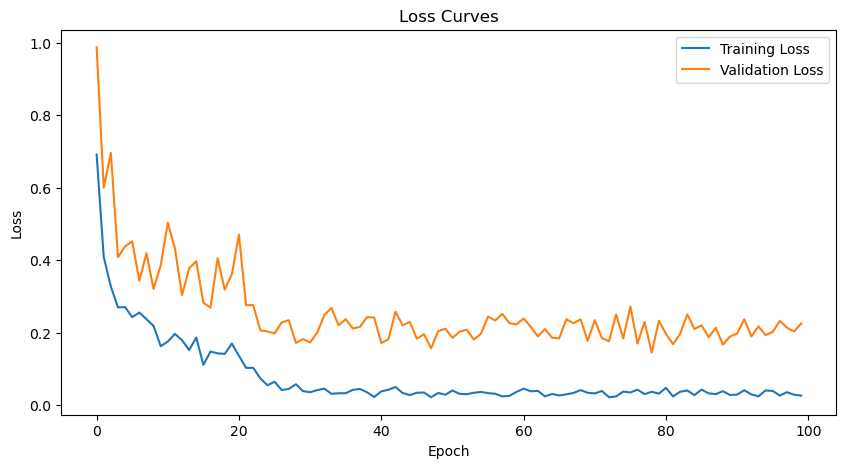

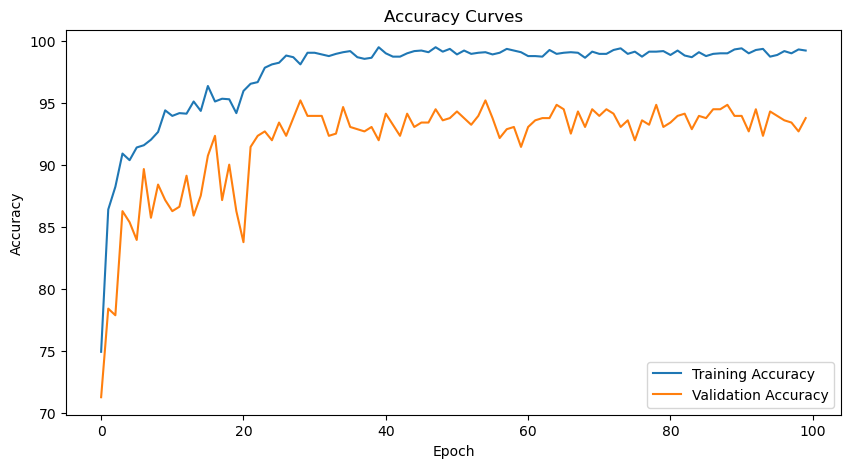

In [10]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

In [12]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to track test loss and accuracy
test_loss = 0.0
correct = 0
total = 0

# Disable gradient computation for testing
with torch.no_grad():
    # Wrap test_loader with tqdm for a progress bar
    test_loop = tqdm(val_loader, desc="Testing")
    for images, labels in test_loop:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        loss = criterion(outputs, labels)

        # Update test loss
        test_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the progress bar description with current loss and accuracy
        test_loop.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)

# Compute average test loss and accuracy
test_loss /= len(val_loader)
test_accuracy = 100 * correct / total

# Print the results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Testing: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, accuracy=93.6, loss=0.152]

Test Loss: 0.1844, Test Accuracy: 93.57%


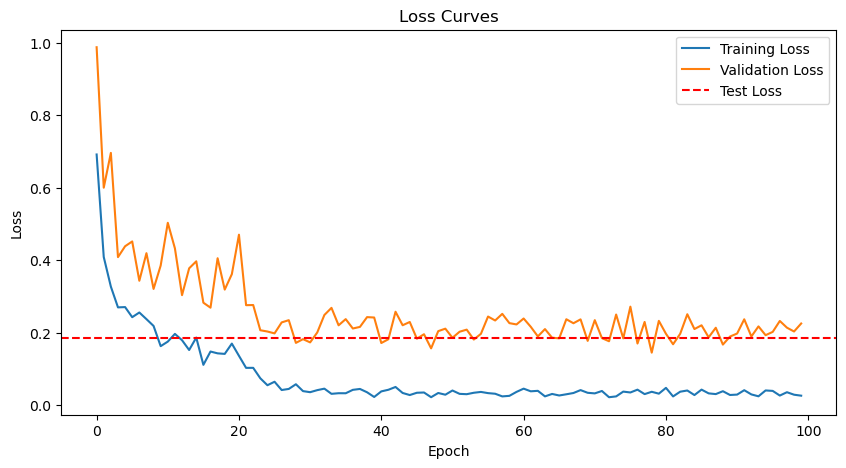

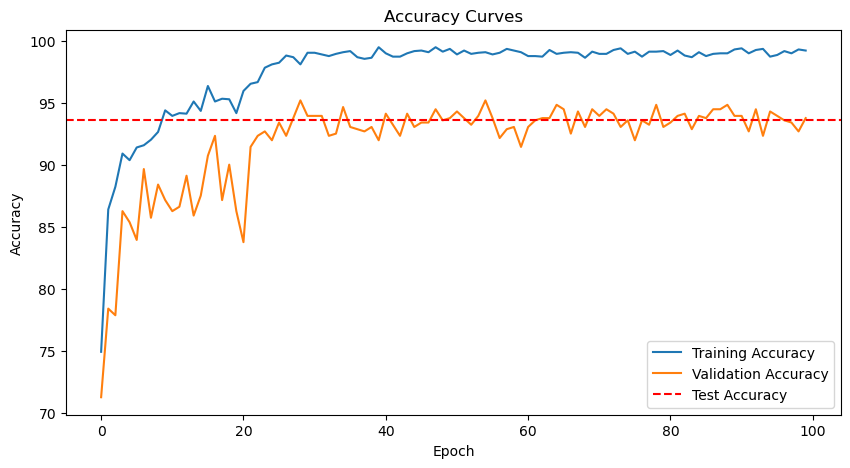

In [13]:
import matplotlib.pyplot as plt

# Plot training, validation, and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Add test loss as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plot training, validation, and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Add test accuracy as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

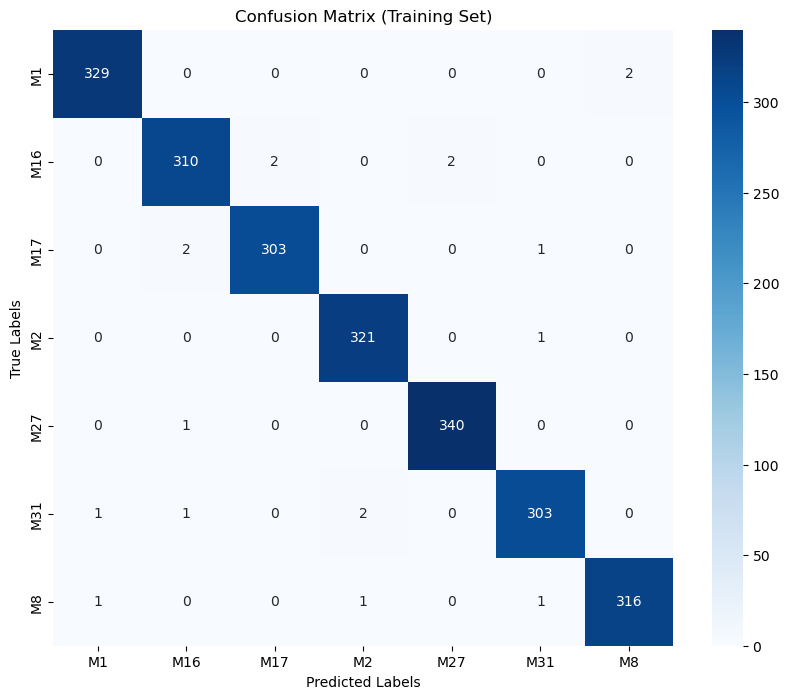

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Disable gradient computation for training set evaluation
with torch.no_grad():
    for images, labels in train_loader:  # Use train_loader instead of test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        _, preds = torch.max(outputs, 1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Training Set)')
plt.show()

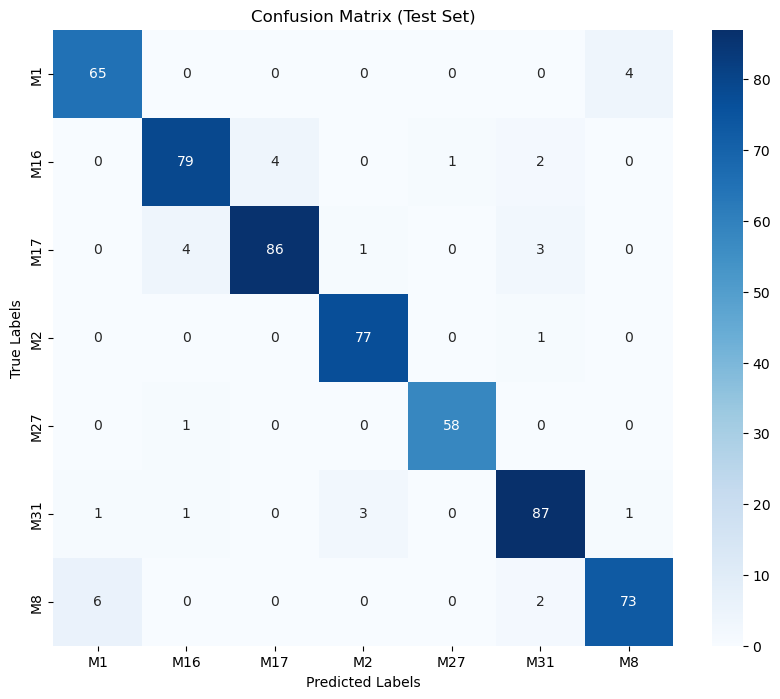

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for test data
all_preds_test = []
all_labels_test = []

# Disable gradient computation for test set evaluation
with torch.no_grad():
    for images, labels in val_loader:  # Use test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        _, preds = torch.max(outputs, 1)

        # Store predictions and labels
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Compute the confusion matrix for test data
cm_test = confusion_matrix(all_labels_test, all_preds_test)

# Plot the confusion matrix for test data
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Test Set)')
plt.show()


In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for training data
all_preds_train = []
all_labels_train = []

# Disable gradient computation for training set evaluation
with torch.no_grad():
    for images, labels in train_loader:  # Use train_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        _, preds = torch.max(outputs, 1)

        # Store predictions and labels
        all_preds_train.extend(preds.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())

# Compute F1 score, precision, and recall for training set
f1_train = f1_score(all_labels_train, all_preds_train, average='weighted')
precision_train = precision_score(all_labels_train, all_preds_train, average='weighted')
recall_train = recall_score(all_labels_train, all_preds_train, average='weighted')

# Print the results
print(f"Training F1 Score: {f1_train:.4f}")
print(f"Training Precision: {precision_train:.4f}")
print(f"Training Recall: {recall_train:.4f}")

Training F1 Score: 0.9915
Training Precision: 0.9915
Training Recall: 0.9915


In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for test data
all_preds_test = []
all_labels_test = []

# Disable gradient computation for test set evaluation
with torch.no_grad():
    for images, labels in val_loader:  # Use test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the Swin Transformer model
        outputs = model(images)  # This returns an object, not just logits
        
        # Extract logits from the model's output object
        logits = outputs.logits  

        # Get predicted class
        _, preds = torch.max(logits, 1)

        # Store predictions and labels
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Compute F1-score, precision, and recall for the test set
f1_test = f1_score(all_labels_test, all_preds_test, average='weighted')  # Change to 'macro' if needed
precision_test = precision_score(all_labels_test, all_preds_test, average='weighted')
recall_test = recall_score(all_labels_test, all_preds_test, average='weighted')

# Print the results
print(f"Test F1 Score: {f1_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")

Test F1 Score: 0.9606
Test Precision: 0.9613
Test Recall: 0.9607


In [20]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for test data
all_preds_test = []
all_labels_test = []

# Disable gradient computation for test set evaluation
with torch.no_grad():
    for images, labels in val_loader:  # Use test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        _, preds = torch.max(outputs, 1)

        # Store predictions and labels
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Compute F1 score, precision, and recall for test set
f1_test = f1_score(all_labels_test, all_preds_test, average='weighted')
precision_test = precision_score(all_labels_test, all_preds_test, average='weighted')
recall_test = recall_score(all_labels_test, all_preds_test, average='weighted')

# Print the results
print(f"Test F1 Score: {f1_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")

Test F1 Score: 0.9267
Test Precision: 0.9279
Test Recall: 0.9268
